In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import newton

#### Question 1 Utility Functions

In [104]:
def interest_rate_simulation(r_init, volatility, kappa, mean_rate, total_years, simulations):
    dt = 1/120
    steps = int(total_years/dt)
    rate_matrix = np.zeros((simulations, steps + 1))
    rate_matrix[:, 0] = r_init

    for i in range(1, steps):
        rate_matrix[:,i] = (np.maximum(rate_matrix[:,i-1], 0) + kappa*(mean_rate - np.maximum(rate_matrix[:,i-1], 0)) *dt 
                    + volatility* np.sqrt(np.maximum(rate_matrix[:,i-1], 0))* np.sqrt(dt)*np.random.normal(0, 1, simulations))
    return rate_matrix

def zero_coupon_bond_price_10yr(rate_t, r_mean, sd, kappa, T, t):
    h1 = np.sqrt(kappa**2 + 2*sd**2)
    h2 = (kappa + h1)/2
    h3 = (2*kappa*r_mean)/sd**2
    A = ((h1 * np.exp(h2*(T - t)))/(h2 * (np.exp(h1*(T - t)) - 1) + h1))**h3
    B = (np.exp(h1*(T - t)) - 1)/(h2 * (np.exp(h1*(T - t)) - 1) + h1)
    return A*np.exp(-B*rate_t)

def ten_year_spot_rate(r_init, volatility, kappa, mean_rate, total_years, simulations):
    rate_simulation = interest_rate_simulation(r_init, volatility, kappa, mean_rate, total_years, simulations)
    zero_coupon_prices = np.array(list(map(lambda rate: zero_coupon_bond_price_10yr(rate, mean_rate, volatility, kappa, 10, 0), rate_simulation)))
    spot_rate = -1/10*np.log(zero_coupon_prices)
    payment_time = np.arange(1, total_years*12 + 1) * 10 - 1
    return spot_rate[:, payment_time]

def discounting_factor(r_init, volatility, kappa, mean_rate, total_years, simulations):
    dt = 1/120
    rate_simulation = interest_rate_simulation(r_init, volatility, kappa, mean_rate, total_years, simulations)
    discount_factors = np.exp(-np.cumsum(rate_simulation*dt , axis = 1))
    payment_time = np.arange(1, total_years*12 + 1) * 10 - 1
    return discount_factors[:, payment_time]

def cash_flow_at_time(t, total_years, PV_prior, rate, N, CPR_t):
    scheduled_total_payment = (PV_prior*rate)/(1 - (1 + rate)**(-N + (t - 1)))
    SPP_t = PV_prior*rate*(1/(1 - (1 + rate)**(-N + (t - 1))) -  1)
    prepayment_amount = (PV_prior - SPP_t)*(1 - (1 - CPR_t)**(1/12))
    cash_flow_t = scheduled_total_payment + prepayment_amount
    return cash_flow_t

def total_principal_payment(t, PV_prior, rate, N, CPR_t):
    SPP_t = PV_prior*rate*(1/(1 - (1 + rate)**(-N + (t - 1))) -  1)
    prepayment_amount = (PV_prior - SPP_t)*(1 - (1 - CPR_t)**(1/12))
    TPP_t = SPP_t + prepayment_amount
    return TPP_t

def refinancing_trigger(R, r_10):
    RI = 0.28 + 0.14*np.arctan(-8.57 + 430*(R - r_10))
    return RI

def burnout(PV_prior, PV0):
    BU = 0.3 + 0.7*(PV_prior/PV0)
    return BU

def seasonal_factor(t):
    SG = np.minimum(1, t/30)
    return SG

def seasoning_factor(month):
    SY  = np.array([0.94, 0.76, 0.74, 0.95, 0.98, 0.92, 0.98, 1.10, 1.18, 1.22, 1.23, 0.98])
    return SY[month]

def Numerix_CPR(t, R, r_10, PV_prior, PV0):
    RI_t = refinancing_trigger(R, r_10)
    BU_t = burnout(PV_prior, PV0)
    SG_t = seasonal_factor(t)
    SY_t = seasoning_factor(int(t-1) % 12)
    CPR_t = RI_t*BU_t*SG_t*SY_t
    return CPR_t

def Numerix_Prepayment_Model(PV_init, total_years, WAC, r_init, kappa, mean_rate, volatility):
    r_monthly = WAC/12
    N = total_years*12
    simulations = 10000
    PV_prior = PV_init
    cash_flow_matrix = np.zeros((simulations, N))
    discount_factors = discounting_factor(r_init, volatility, kappa, mean_rate, total_years, simulations)
    ten_year_spot_yield = ten_year_spot_rate(r_init, volatility, kappa, mean_rate, total_years, simulations)

    for t in range(1 , N + 1):
        CPR_Numerix = Numerix_CPR(t, WAC, ten_year_spot_yield[:, t - 1], PV_prior, PV_init)
        cash_flow_matrix[:, t - 1] = cash_flow_at_time(t, total_years, PV_prior, r_monthly, N, CPR_Numerix)
        total_principal_payment_t = cash_flow_matrix[:, t - 1] - PV_prior*r_monthly
        PV_prior = PV_prior - total_principal_payment_t

    mortgage_value = np.mean(np.sum(discount_factors*cash_flow_matrix, axis = 1))
    return mortgage_value

#### Q1.  CIR model inputs :  $ r_0 = 0.078 \quad \bar{r} = 0.08 \quad \sigma = 0.12 \quad k = 0.6 $
#### MBS inputs : $ WAC = 0.08  \quad M = 30 years  \quad   Notional = 100000 \quad \quad \quad $ 

#### (a) MBS Price

In [105]:
Numerix_Prepayment_Model(100000, 30, 0.08, 0.078, 0.6, 0.08, 0.12)

100841.80816317236

#### (b) MBS Price plot for k = [0.3, 0.9]

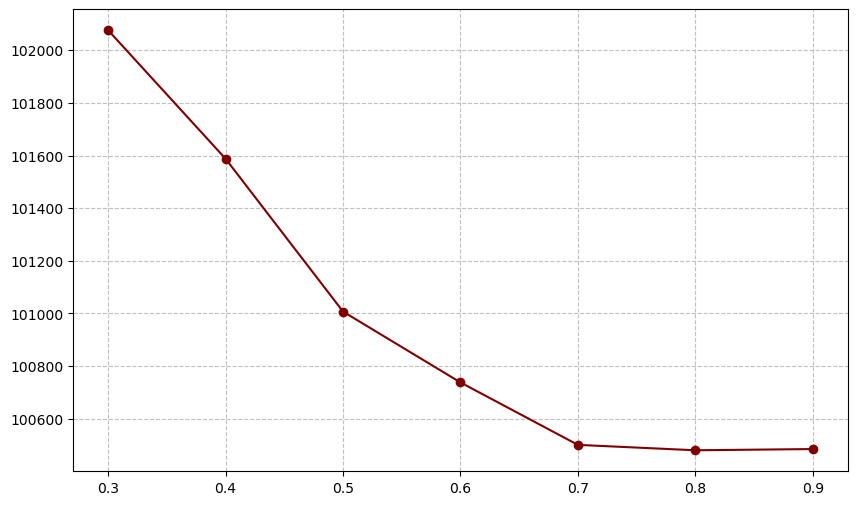

In [106]:
prices = []
kappas = []
for i in range(3, 9+1):
    k = i*0.1
    kappas.append(k)
    prices.append(Numerix_Prepayment_Model(100000, 30, 0.08, 0.078, k, 0.08, 0.12))
plt.figure(figsize=(10,6))
plt.grid(color="silver", linestyle="--")
plt.plot(kappas, prices, color='maroon', marker='o')

#### (c) MBS Price plot for $ \bar{r} =$ [0.03, 0.09] 

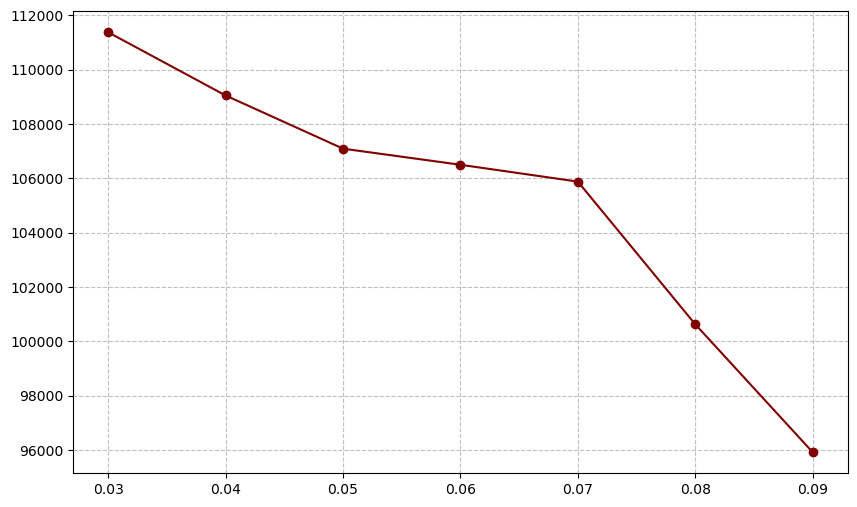

In [107]:
prices = []
r_bars = []
for i in range(3, 9+1):
    r_bar = i*0.01
    r_bars.append(r_bar)
    prices.append(Numerix_Prepayment_Model(100000, 30, 0.08, 0.078, 0.6, r_bar, 0.12))
plt.figure(figsize=(10,6))
plt.grid(color="silver", linestyle="--",)
plt.plot(r_bars, prices, color='maroon', marker='o')

#### Question 2 Utility Functions

In [108]:
def computeOASDiscountFactor(OAS, initial_rate, sigma, kappa, mean_rate, total_years, simulations):
    dt = 1/120
    generated_rates = interest_rate_simulation(initial_rate, sigma, kappa, mean_rate, total_years, simulations)
    OAS_discount_factor = np.exp(-np.cumsum((generated_rates + OAS)*dt , axis = 1))
    
    payment_time_index = np.arange(1, total_years*12 + 1) * 10 - 1
    return OAS_discount_factor[:, payment_time_index]


def computeNumerixPrepayment_OAS(OAS, principal_amount, total_years, contractual_rate, initial_rate, kappa, mean_rate, sigma):
    monthly_rate = contractual_rate/12
    periods = total_years*12
    simulations = 10000
    principal_remaining = np.zeros((simulations, periods))
    prior_balance = principal_amount
    cashflows = np.zeros((simulations, periods))

    OAS_discount_factor = computeOASDiscountFactor(OAS, initial_rate, sigma, kappa, mean_rate, total_years, simulations)

    spot_rate_tenyr = ten_year_spot_rate(initial_rate, sigma, kappa, mean_rate, total_years, simulations)

    for i in range(1 , periods + 1):
        numerix_CPR = Numerix_CPR(i, contractual_rate, spot_rate_tenyr[:, i - 1], prior_balance, principal_amount)
        cashflows[:, i - 1] = cash_flow_at_time(i, total_years, prior_balance, monthly_rate, periods, numerix_CPR)
        principal_payment_total = cashflows[:, i - 1] - prior_balance * monthly_rate
        prior_balance = prior_balance - principal_payment_total

    MBS_value = np.mean(np.sum(OAS_discount_factor * cashflows, axis = 1))
    return MBS_value


def optimizeFunction(OAS, market_value):
    model_value = computeNumerixPrepayment_OAS(OAS = OAS, 
                                       principal_amount = 100000, total_years = 30, contractual_rate = 0.08, 
                                       initial_rate = 0.078, kappa = 0.6, mean_rate = 0.08, sigma = 0.12)
    return model_value - market_value


def calculateOAS(market_value):
    OAS_estimate = newton(optimizeFunction, 0, args = (market_value,), maxiter=100, tol=1e-50)
    return OAS_estimate

#### Q2. OAS for MBS Price = 102000

In [ ]:
calculateOAS(102000)

#### Question 3 Utility Functions

In [ ]:
def evaluatePrices(OAS, loan_amt, maturity, WAC, r0, k, r_bar, sigma):
    increment = 5*(0.01/100)
    price_higher = computeNumerixPrepayment_OAS(OAS + increment, loan_amt, maturity, WAC, r0, k, r_bar, sigma)
    price_lower = price_higher = computeNumerixPrepayment_OAS(OAS - increment, loan_amt, maturity, WAC, r0, k, r_bar, sigma)
    price_current = price_higher = computeNumerixPrepayment_OAS(OAS, loan_amt, maturity, WAC, r0, k, r_bar, sigma)
    return [price_current, price_higher, price_lower]

def calculateOASDuration(prices):
    price_current = prices[0]
    price_higher = prices[1]
    price_lower = prices[2]
    increment = 5*(0.01/100)
    duration_OAS = (price_lower - price_higher)/(2*increment*price_current)
    return duration_OAS

def calculateOASConvexity(prices):
    price_current = prices[0]
    price_higher = prices[1]
    price_lower = prices[2]
    increment = 5*(0.01/100)
    convexity_OAS = (price_lower + price_higher - 2*price_current)/(2 * (increment)**2 * price_current)
    return convexity_OAS

#### Q3. OAS Adjusted Duration and Convexity

In [ ]:
OAS_est = -0.0017999304306884518
prices = evaluatePrices(OAS_est, 100000, 30, 0.08, 0.078, 0.6, 0.08, 0.12)
OAS_Duration = calculateOASDuration(prices)
OAS_Convexity = calculateOASConvexity(prices)
print(f"OAS Duration: ", OAS_Duration)
print(f"OAS Convexity: ", OAS_Convexity)

#### Question 4 Utility functions

In [ ]:
def calculate_io_po(PV0, total_years, WAC, r0, k, r_mean, sd):
   
    # initialize parameters
    r = WAC/12
    N = total_years*12
    paths = 10000
    PV_previous = np.array([PV0]*paths)
    ct = np.zeros((paths, N))
    
    # Initialize PO, IO portion of the MBS
    Interest = np.zeros((paths, N))
    Principal = np.zeros((paths, N))
    
    # find discount factor
    dft = discounting_factor(r0, sd, k, r_mean, total_years, paths)
    
    # find 10 year spot yield
    r_10 = ten_year_spot_rate(r0, sd, k, r_mean, total_years, paths)
     
    for t in range(1 , N + 1):
        # find CPRt
        CPRt_Numerix = Numerix_CPR(t, WAC, r_10[:, t - 1], PV_previous, PV0)
        # find cash flow at t
        ct[:, t - 1] = cash_flow_at_time(t, total_years, PV_previous, r, N, CPRt_Numerix)
        # find total principal payment
        Interest[:, t - 1] = PV_previous*r
        TPPt = ct[:, t - 1] - PV_previous*r
        Principal[:, t - 1] =  TPPt
        # Update next period present value, PVt
        PV_previous = PV_previous - TPPt

   
    IO = np.mean(np.sum(dft*Interest, axis = 1))
    PO = np.mean(np.sum(dft*Principal, axis = 1))
    
    return [IO, PO]

In [ ]:
r_means = np.array([i*0.01 for i in range(3, 10)])
io_po_all = []
for r_mean in r_means:
    io_po = calculate_io_po(100000, 30, 0.08, 0.078, 0.6, r_mean, 0.12)
    io_po_all.append((r_mean ,io_po[0], io_po[1]))
io_po_df = pd.DataFrame(io_po_all, columns=['R Mean', 'Interest Only', 'Principal Only'])
io_po_df

In [ ]:
plt.figure(figsize=(10,6))
plt.grid(linestyle="--", color="silver")
plt.plot(io_po_df["R Mean"], io_po_df["Interest Only"], label="Interest Only", marker='o')
plt.plot(io_po_df["R Mean"], io_po_df["Principal Only"], label="Principal Only", marker='o')
plt.legend()